<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/hungarian/ransac/ransac_gomb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#RANSAC gömbök

Ebben a leckében gömböket fogunk keresni egy pontfelhőben.

Először egy függvényt készítünk regressziós gömb illesztésére. Ezután generálunk egy zajos pontfelhőt gömbökkel, majd többszörös RANSAC gömb keresést hajtunk végre.

Először importáljuk a szükséges Python modulokat.

* math - matematikai függvények
* random - álvéletlen számok generálása
* numpy - vektorok, mátrixok kezelése, műveletek
* plotly - 3D ábrák készítése

In [49]:
import numpy as np
from math import sin, cos, pi, sqrt
from random import random, seed
import plotly.graph_objects as go
from matplotlib import pyplot as plt

##Regressziós gömb

Négy vagy több ponton átmenő gömb paramétereit (középpont: $x_0, y_0, z_0$ és sugár: r) keressük.

$(x−x_0)^2+(y−y_0)^2+(z−z_0)^2=r^2$

A négyzetre emelések elvégzése és összevonások után az alábbi egyenletet kapjuk:

$y^2+x^2+z^2−2x_0x−2y_0y−2z_0z+x_0^2+y_0^2+z_0^2−r^2=0$

Az alábbi helyettesítések után lineáris egyenletet kapunk:

$a_1=−2x_0$

$a_2=−2y_0$

$a_3=−2z_0$

$a_4=x_0^2+y_0^2+z_0^2−r^2$

$x^2+y^2+z^2+a_1x+a_2y+a_3z+a_4=0$

Minden pontra felírhatunk egy egyenletet az ismeretlenekre ($a_1, a_2, a_3, a_4$):

$x_i^2+y_i^2+z_i^2+a_1x_i+a_2y_i+a_3z_i+a_4=0$

$i=1..n$

Készítsük el a Python függvényt, mely a legkisebb négyzetek módszerét alkalmazza.

In [50]:
def sphere(x_, y_, z_):
  """ x_, y_, z_ are numpy arrays of coordinates of four or more points
      returns x0, y0, z0 and r as a tuple"""
  n_ = x_.shape[0]
  a = np.c_[x_, y_, z_, np.full(n_, 1, 'float64')]
  b = -np.square(x_) - np.square(y_) - np.square(z_)
  res = np.linalg.lstsq(a, b, rcond=None)[0]
  return -0.5 * res[0], -0.5 * res[1], -0.5 * res[2], \
          sqrt((res[0]**2 + res[1]**2 + res[2]**2)/4 - res[3])

A fenti függvényből hiányzik a hibakezelés, például négynél kevesebb pont megadása esetén vagy négy egy síkba eső pontnál hibára fut. Bővítse ki a kódot hibakezeléssel!

Egyszerű teszt négy pontra:

In [51]:
x_sp = np.array([102.167, 102.178, 102.145, 102.135])
y_sp = np.array([99.674, 99.754, 99.752, 99.675])
z_sp = np.array([58.389, 58.383, 58.411, 58.414])
x0, y0, z0, r = sphere(x_sp, y_sp, z_sp)
print("A gömb egyenlete:", end=' ')
print(f"(x - {x0:.3f})^2 + (y - {y0:.3f})^2 + (z - {z0:.3f})^2 = {r:.3f}")
print("Javítások:", end =' ')
for x_i, y_i, z_i in zip(x_sp, y_sp, z_sp):
    print(f"{((x_i - x0)**2 + (y_i - y0)**2 +(z_i - z0)**2 - r**2):.3f}", end=' ')
print()

A gömb egyenlete: (x - 101.985)^2 + (y - 99.725)^2 + (z - 58.187)^2 = 0.277
Javítások: -0.000 -0.000 -0.000 -0.000 


Inicializáljuk a véletlenszám generátort, hogy a különböző futtatásoknál eltérő adatokat generáljunk.

In [52]:
np.random.seed()
seed()

Adjunk meg néhány paramétert a gömbökhöz és generáljunk véletlen pontokat.

In [53]:
x_range, y_range, z_range = 100, 100, 100   # working in a x_range * y_range * z_range  metres box
n = 10                                  # number of spheres to generate
min_r = 3                               # minimum radius
max_r = 6                               # maximum radius
xc = np.random.rand(n) * x_range        # coordinates of center of spheres
yc = np.random.rand(n) * y_range
zc = np.random.rand(n) * z_range
r = np.round(min_r + np.random.rand(n) * (max_r - min_r), decimals=1) # radii

## Mintaadatok generálása

In [54]:
points_per_sphere = 100                 # number of points on thesurface of each sphere
max_noise = 0.1
k = 1                                   # number of noise points = k * point_per_sphere
x = np.zeros((n + k) * points_per_sphere) # arrays to store points on surface
y = np.zeros((n + k) * points_per_sphere) # and points_per_sphere number of random noise
z = np.zeros((n + k) * points_per_sphere)
for i in range(n):                        # for each sphere
  for j in range(points_per_sphere):      # for the number of points on the sphere
    alpha = random() * pi * 2             # azimut for the point (0 - 360 degree)
    beta = random() * pi - pi / 2         # elevation angle (-90 - 90 degree)
    ind = i * points_per_sphere + j       # index for the point
    x[ind] = xc[i] + r[i] * cos(beta) * cos(alpha)  # point on surface
    y[ind] = yc[i] + r[i] * cos(beta) * sin(alpha)
    z[ind] = zc[i] + r[i] * sin(beta)
# extra random points
x[n*points_per_sphere: (n+k)*points_per_sphere] = np.random.rand(k * points_per_sphere) * x_range
y[n*points_per_sphere: (n+k)*points_per_sphere] = np.random.rand(k * points_per_sphere) * y_range
z[n*points_per_sphere: (n+k)*points_per_sphere] = np.random.rand(k * points_per_sphere) * z_range
# random noise to all points in -max_noise +max_noise range
x += np.random.rand((n+k)*points_per_sphere) * max_noise - max_noise / 2
y += np.random.rand((n+k)*points_per_sphere) * max_noise - max_noise / 2

Nézzük meg a generált pontokat!

In [55]:
fig = go.Figure(data=[go.Scatter3d(x=x[:n * points_per_sphere], y=y[:n * points_per_sphere], z=z[:n * points_per_sphere],
                                   mode='markers', marker=dict(size=2, color='green')),
                      go.Scatter3d(x=x[n * points_per_sphere:], y=y[n * points_per_sphere:], z=z[n * points_per_sphere:],
                                   mode='markers', marker=dict(size=2, color='red'))])
# Add title to the axes
fig.update_layout(scene=dict(
                    aspectmode='manual',
                    aspectratio=dict(x=1, y=1, z=1),
                    xaxis_title='X',
                    yaxis_title='Y',
                    zaxis_title='Z'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10)
)

Statikus ábra

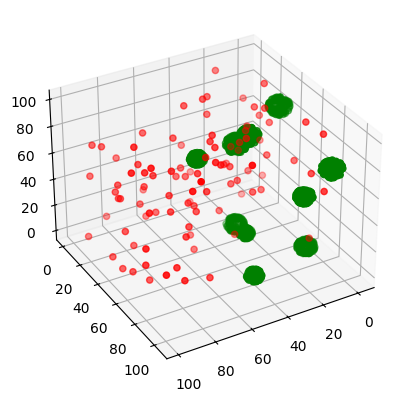

In [56]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x[:n*points_per_sphere], y[:n*points_per_sphere], z[:n*points_per_sphere], color='green')
ax.scatter(x[n*points_per_sphere:], y[n*points_per_sphere:], z[n*points_per_sphere:], color='red')
ax.view_init(32, 60)              # change the two view directions (in degree)

##RANSAC

Készítsünk függvényeket a RANSAC elemi műveleteihez!

n különböző véletlen pont kiválasztása az összes pont közül:

In [57]:
def rand_pnts(x_, y_, z_, n_=4):
  """ select n_ points
      return tuple of x, y, z numpy arrays
  """
  m = x_.shape[0] # number of items
  l = []
  while len(l) != n_:
    l = list(set(np.random.randint(m, size=n_))) # remove repeated random integers
  return (x_[l], y_[l], z_[l])

Pontok távolsága egy gömbtől:

In [58]:
def ransac_dist(x_, y_, z_, sph_):
    """ calculate distance from the surface of sphere
        and returns distances as numpy vector
        shp_ is a tuple of x0, y0, z0, r
    """
    d_ = np.abs(np.sqrt(np.square(x_ - sph_[0]) + np.square(y_ - sph_[1]) + np.square(z_ - sph_[2])) - sph_[3])
    return d_

Állítsunk be néhány konstanst és készítsünk egy másolatot a pontokról, hogy az eredeti pontokat megőrizzük.

In [62]:
tol = max_noise / 2      # distance tolerance from the surface of sphere
max_iter = n * k * points_per_sphere
x1 = np.copy(x) # preserve original coordinates
y1 = np.copy(y) # we work on a copy
z1 = np.copy(z)
spheres = []    # list for found spheres

In [63]:
for _ in range(n**2):
    best_n = 0
    for i in range(max_iter):
        x4, y4, z4 = rand_pnts(x1, y1, z1)  # four random points
        x0, y0, z0, r0 = sphere(x4, y4, z4) # parameters of sphere
        d4 = ransac_dist(x1, y1, z1, np.array([x0, y0, z0, r0]))
        on4 = d4 < tol                    # select close points to sphere
        act_n = d4[on4].shape[0]          # number of close points
        if act_n > best_n:
            best_n = act_n
            best_on = np.copy(on4)
            best_x0, best_y0, best_z0, best_r0 = x0, y0, z0, r0
            if act_n > 0.8 * points_per_sphere:
                break                       # short cut for very good match
    # radius in the given range and there are enough points on surface
    if best_n > points_per_sphere // 2:
        if min_r <= best_r0 <= max_r:
            # recalculate circle params by LSM
            best_x0, best_y0, best_z0, best_r0 = sphere(x1[best_on], y1[best_on], z1[best_on])
            spheres.append([best_x0, best_y0, best_z0, best_r0, best_n])
            x1 = x1[np.invert(best_on)]     # remove used points
            y1 = y1[np.invert(best_on)]
            z1 = z1[np.invert(best_on)]

Írjuk ki az eredeti és a megtalált gömbök paramétereit!

In [61]:
s = np.sort(np.array(spheres), axis=0)          # convert list to array
ss = np.sort(np.c_[xc, yc, zc, r], axis=0)      # put together original sphere data
print
print(f"Found spheres: {len(spheres)}")
print("   Found spheres                             Original spheres")
print("    x0       y0       z0       r       n      x0       y0       z0      r")
for i in range(max(n, len(spheres))):
    if i < len(spheres):
        buf = f"{s[i,0]:8.2f} {s[i,1]:8.2f} {s[i,2]:8.2f} {s[i,3]:8.2f} {int(s[i,4]):4d}"
    else:
        buf = f"{' ':42s}"
    if i < n:
        buf += f"{ss[i,0]:8.2f} {ss[i,1]:8.2f} {ss[i,2]:8.2f} {ss[i,3]:6.2f}"
    print(buf)

Found spheres: 10
   Found spheres                             Original spheres
    x0       y0       z0       r       n      x0       y0       z0      r
    3.46    39.12     4.51     3.29   83    3.47    39.13     4.51   3.30
    9.60    39.98     9.40     3.70   87    9.60    39.99     9.40   3.70
   10.56    47.70     9.76     3.70   88   10.55    47.70     9.76   3.70
   22.24    48.26    12.01     4.10   89   22.23    48.25    12.01   4.10
   27.68    56.96    63.13     4.50   90   27.67    56.96    63.13   4.50
   31.74    60.33    72.12     4.70   90   31.75    60.33    72.12   4.70
   32.36    80.13    73.83     5.00   94   32.37    80.13    73.83   5.00
   32.75    89.73    80.91     5.20   94   32.76    89.75    80.91   5.20
   45.90    95.74    86.34     5.30   96   45.89    95.74    86.35   5.30
   54.51    99.76    88.32     5.51   98   54.51    99.76    88.31   5.50
